In [43]:
import os
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import time
from tqdm import tqdm

import torch
import torchvision.models as models
from ptflops import get_model_complexity_info

from itertools import product

from src.train.config import Config as ModelConfig
from src.models.pct.point_transformer_cls import get_model as get_pct, get_loss as get_pct_loss
from src.models.pt.model import get_model as get_pt, get_loss as get_pt_loss

# sys.path.append('src')

In [2]:
for i in range(1, 5):
    fp = os.path.join("outputs/test", str(i), "progress.csv")
    df = pd.read_csv(fp)
    print(max(df["V_Accuracy"]))

0.8946731234866828
0.8595641646489104
nan
nan


In [3]:

device = 'cpu'

def get_model(model_name, method, num_points, num_class, input_dim, init_hidden_dim, k, device,further_ds=0):
    model_config = ModelConfig(method, num_points, num_class, input_dim, init_hidden_dim, k,tome_further_ds=1.000-further_ds)
    print(model_config.tome_further_ds)
    if model_name == "pct":
        model = get_pct(model_config).float().to(device)
        loss_fn = get_pct_loss()
    elif model_name == "pt":
        model = get_pt(model_config).float().to(device)
        loss_fn = get_pt_loss()
    else:
        raise ValueError(f"The provided model_name is not supported: {model_name}")
    
    return model, loss_fn

In [4]:
sys.path.append('src/train')

# from train_model import get_model

model, _ = get_model(
    "pct", 
    "tome_ft", 
    1024,
    40,
    3,
    64,
    32,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

print('FLOPs:', flops)
print('Parameters:', params)

1.0


PCT(
  2.82 M, 102.381% Params, 557.79 MMac, 99.836% MACs, 
  (conv1): Conv1d(192, 0.007% Params, 196.61 KMac, 0.035% MACs, 3, 64, kernel_size=(1,), stride=(1,), bias=False)
  (conv2): Conv1d(4.1 k, 0.149% Params, 4.19 MMac, 0.751% MACs, 64, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample1): TOME(
    8.45 k, 0.307% Params, 4.39 MMac, 0.786% MACs, 
    (merge): Merge(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (conv): Conv1d(8.19 k, 0.298% Params, 4.19 MMac, 0.751% MACs, 64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(256, 0.009% Params, 131.07 KMac, 0.023% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 65.54 KMac, 0.0

In [5]:
model, _ = get_model(
    "pt", 
    "tome_xyz", 
    1024,
    40,
    3,
    32,
    16,  
    device
)

input_tensor = torch.rand(32, 1024, 3).to(device)
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

# print('FLOPs:', flops)
# print('Parameters:', params)

print(flops)

1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
PointTransformerCls(
  7.91 M, 100.000% Params, 2.34 GMac, 99.921% MACs, 
  (backbone): Backbone(
    7.76 M, 98.098% Params, 2.34 GMac, 99.915% MACs, 
    (fc1): Sequential(
      1.18 k, 0.015% Params, 1.25 MMac, 0.053% MACs, 
      (0): Linear(128, 0.002% Params, 131.07 KMac, 0.006% MACs, in_features=3, out_features=32, bias=True)
      (1): ReLU(0, 0.000% Params, 32.77 KMac, 0.001% MACs, )
      (2): Linear(1.06 k, 0.013% Params, 1.08 MMac, 0.046% MACs, in_features=32, out_features=32, bias=True)
    )
    (transformer1): MyAttention2(
      1.35 M, 17.014% Params, 1.38 GMac, 58.854% MACs, 
      (fc1): Linear(16.9 k, 0.214% Params, 17.3 MMac, 0.739% MACs, in_features=32, out_features=512, bias=True)
      (fc2): Linear(16.42 

In [6]:

time_dict = dict()

for model_name in ["pct", "pt"]:
    time_dict[model_name] = dict()

    if model_name == "pct":
        hidden_size = 64
        k = 32
    else:
        hidden_size = 32
        k = 16

    for strat,downsample in product(["normal", "tome_ft", "tome_xyz", "random"],[0.0]):
        model, _ = get_model(
            model_name=model_name, 
            method=strat, 
            num_points=1024,
            num_class=40,
            input_dim=3,
            init_hidden_dim=hidden_size,
            k=k,  
            device=device,
            # further_ds=downsample
        )

        N = 7
        times = list()
        for i in range(N):
            input = torch.rand(16, 1024, 3).to(device)
            start = time.time()
            model(input)
            end = time.time()
            times.append(end - start)

        times = np.array(times)
        time_dict[model_name][strat] = times
            

1.0
1.0
1.0
1.0
1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing 

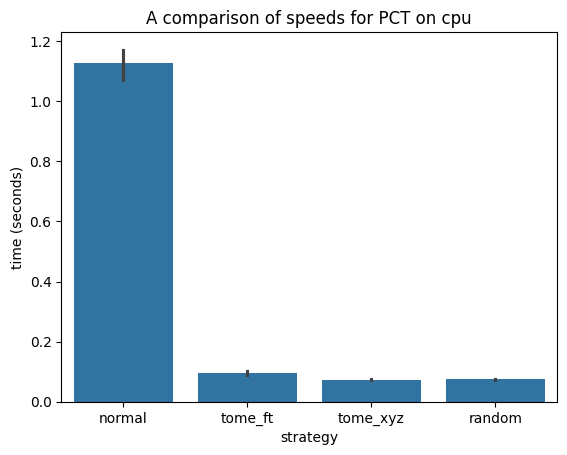

In [7]:
melted = pd.DataFrame(time_dict).reset_index().melt(id_vars = 'index').explode(column='value').reset_index(drop=True)
melted 
ax = sns.barplot(melted[melted['variable'] == 'pct'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PCT on {device}')
ax.get_figure().savefig(f'figures/prune_speeds_pct_{device}.png')

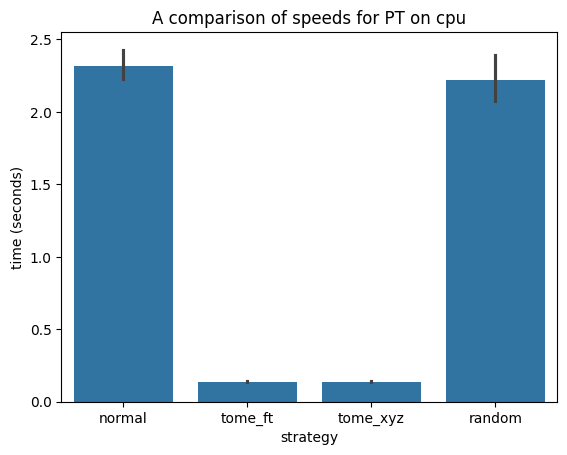

In [8]:
ax = sns.barplot(melted[melted['variable'] == 'pt'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')
ax.set(title=f'A comparison of speeds for PT on {device}')
ax.get_figure().savefig(f'figures/prune_speeds_pt_{device}.png')

In [85]:
device='cpu'
rows = []
for model_name in ["pct", "pt"]:
    # time_dict2[model_name] = dict()

    if model_name == "pct":
        hidden_size = 64
        k = 32
    else:
        hidden_size = 32
        k = 16

    for strat,downsample in tqdm(product(["normal", "tome_ft",],[0.0, 0.15, 0.3]),total=6):
        model, _ = get_model(
            model_name=model_name, 
            method=strat, 
            num_points=1024,
            num_class=40,
            input_dim=3,
            init_hidden_dim=hidden_size,
            k=k,  
            device=device,
            further_ds=downsample
        )

        input_tensor = torch.rand(32, 1024, 3).to(device)
        flops, params = get_model_complexity_info(model, (1024, 3), as_strings=False, print_per_layer_stat=False)


        N = 7
        times = list()
        for i in range(N):
            input = torch.rand(16, 1024, 3).to(device)
            start = time.time()
            model(input)
            end = time.time()
            # times.append(end - start)

            rows.append({
                'model':model_name, 
                'strategy':strat,
                'downsample':downsample,
                'flops':flops,
                # 'params':params,
                'time':end - start,
            })

  0%|          | 0/6 [00:00<?, ?it/s]

1.0


 17%|█▋        | 1/6 [00:07<00:36,  7.39s/it]

0.85
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False


 33%|███▎      | 2/6 [00:14<00:27,  6.98s/it]

0.7
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False


 50%|█████     | 3/6 [00:20<00:19,  6.66s/it]

1.0


 67%|██████▋   | 4/6 [00:21<00:08,  4.29s/it]

0.85
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False


 83%|████████▎ | 5/6 [00:21<00:02,  2.94s/it]

0.7
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False


  0%|          | 0/6 [00:00<?, ?it/s]

1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False


 17%|█▋        | 1/6 [00:18<01:30, 18.20s/it]

0.85
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False


 33%|███▎      | 2/6 [00:35<01:10, 17.65s/it]

0.7
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False


 50%|█████     | 3/6 [00:52<00:51, 17.25s/it]

1.0
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False
initing tome with downsampling factor = 1.0 and use_xyz = False


 67%|██████▋   | 4/6 [00:53<00:22, 11.05s/it]

0.85
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False
initing tome with downsampling factor = 0.85 and use_xyz = False


 83%|████████▎ | 5/6 [00:55<00:07,  7.53s/it]

0.7
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False
initing tome with downsampling factor = 0.7 and use_xyz = False


100%|██████████| 6/6 [00:56<00:00,  9.39s/it]


In [86]:
df_sample = pd.DataFrame(rows)
bases_pct = df_sample[(df_sample.model == 'pct') & (df_sample.strategy == 'normal') & (df_sample.downsample == 0.00)]
bases_pct = bases_pct[['time','flops',]].mean()

bases_pt = df_sample[(df_sample.model == 'pt') & (df_sample.strategy == 'normal') & (df_sample.downsample == 0.00)]
bases_pt = bases_pt[['time','flops']].mean()
bases_pt

df_sample.loc[df_sample.model == 'pct',['time','flops']] = df_sample[df_sample.model == 'pct'][['time','flops']] / bases_pct
df_sample.loc[df_sample.model == 'pt',['time','flops']] = df_sample[df_sample.model == 'pt'][['time','flops']] / bases_pt



/tmp/ipykernel_938950/2559260792.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.         1.         1.         1.         1.         1.
 1.         0.85862119 0.85862119 0.85862119 0.85862119 0.85862119
 0.85862119 0.85862119 0.72494785 0.72494785 0.72494785 0.72494785
 0.72494785 0.72494785 0.72494785 0.25514484 0.25514484 0.25514484
 0.25514484 0.25514484 0.25514484 0.25514484 0.18710249 0.18710249
 0.18710249 0.18710249 0.18710249 0.18710249 0.18710249 0.12871094
 0.12871094 0.12871094 0.12871094 0.12871094 0.12871094 0.12871094]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sample.loc[df_sample.model == 'pct',['time','flops']] = df_sample[df_sample.model == 'pct'][['time','flops']] / bases_pct


/tmp/ipykernel_938950/3873372223.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


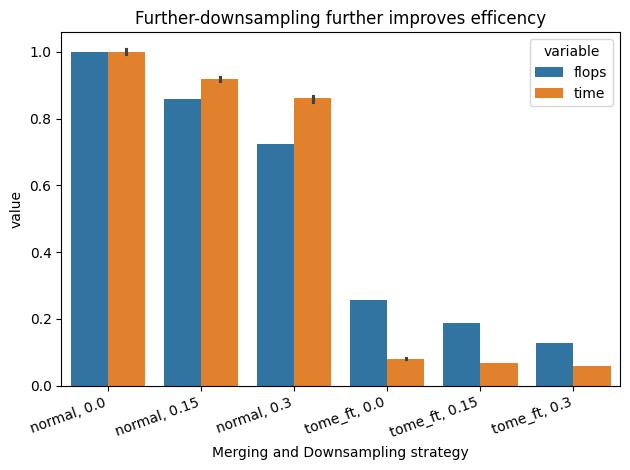

In [88]:
# melted2 = pd.DataFrame(time_dict2).reset_index().rename(columns={'level_0':'agg','level_1':'downsample'}).explode(column=['pct','pt']).melt(id_vars = ['agg','downsample']).rename(columns={'value':'Time'})#.explode(column='value').reset_index(drop=True)
melted2 = df_sample.rename(columns={'strategy':'agg'}).melt(id_vars=['model','agg','downsample'])
melted2['Merging and Downsampling strategy'] = melted2.apply((lambda row: (f'{row["agg"]}, {row["downsample"]}')),axis=1)
ax = sns.barplot(melted2[melted2['model'] == 'pct'],x='Merging and Downsampling strategy',y='value',hue='variable')
ax.set(title=f'Further-downsampling further improves efficency')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=20, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pct_{device}.png')
print()
# melted2

/tmp/ipykernel_938950/1976147840.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


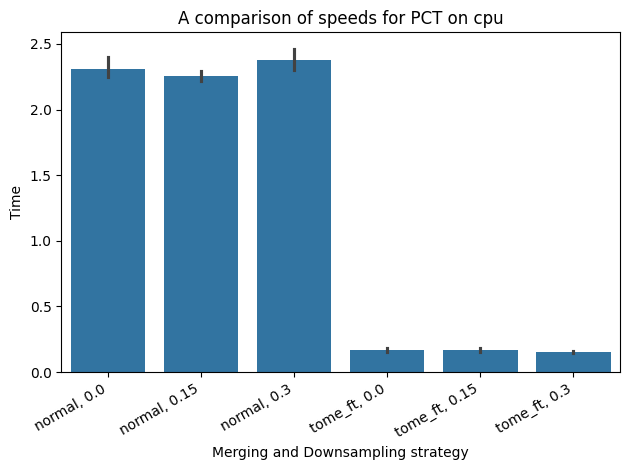

In [46]:
# ax.set(xlabel='strategy', ylabel='time (seconds)')
ax = sns.barplot(melted2[melted2['variable'] == 'pt'],x='Merging and Downsampling strategy',y='Time')
ax.set(title=f'A comparison of speeds for PCT on {device}')
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=30, 
    horizontalalignment='right'
)
ax.get_figure().tight_layout()
ax.get_figure().savefig(f'figures/downsample_speeds_pt_{device}.png')
print()